<h2>Phase I : Bayesian Network with Independant Random Variables </h2>

In [1]:
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import os as os
%matplotlib inline

In [2]:
def get_data_matrix(file_path):    
    '''Strip out the first row and first column and return data matrix'''
    data = np.loadtxt(file_path, delimiter=',', skiprows=1)
    return data[:,1:]

In [3]:
def get_reading_for_diff_days(data_matrix,train_days):
    '''Gets the readings of sensors and their timestamps across different days'''
    
    no_of_sensors = data_matrix.shape[0]
    time_stamps= data_matrix.shape[1]/train_days

    consolidated_readings = []
    
    for sensor_id in range(0,no_of_sensors):
        
        row_list = []
        
        for time_stamp in range(0,time_stamps):
            
            day1_idx = time_stamp + (time_stamps*0)
            day2_idx = time_stamp + (time_stamps*1)
            day3_idx = time_stamp + (time_stamps*2)
            
            row_list.append((data_matrix[sensor_id,day1_idx],data_matrix[sensor_id,day2_idx],data_matrix[sensor_id,day3_idx]))
        
        consolidated_readings.append(row_list)
    
    return consolidated_readings

<h3> Estimate Gaussian Model parameters : <font color= 'green'>N(μ,σ)</font> </h3>

In [4]:
def get_params(consolidated_readings):
    '''Compute the mean and variance of each readings and store it in an numpy matrix'''
    max_sensors = consolidated_readings.shape[0]
    max_time_stamps = consolidated_readings.shape[1]

    params = np.zeros((max_sensors,max_time_stamps),dtype=tuple)

    for i in range(0,max_sensors):
        for j in range(0,max_time_stamps):        

            _mean= np.mean(consolidated_readings[i,j])
            _var = np.var(consolidated_readings[i,j])

            params[i,j] = (_mean, _var)

    return params

<h3> Active Inference I : <font color = 'green'>Window Sliding</font> </h3>

In [5]:
def chunks(_list,size):
    '''Get Chunks of size size from a list _list '''
    for x in xrange(0, len(_list),size):
        yield _list[x:x+size]

In [6]:
def get_windows(no_of_sensors,no_of_cols,budget):    
    '''Get the window indices for each column/each time-stamp'''
    pool = cycle(range(0,no_of_sensors))

    final_list = []

    if budget == 0 :
        
        for _ in range(0,no_of_cols):
            final_list.append([])
            
        return final_list
    
    else:
        
        for _id,x in enumerate(pool):
            if _id == budget * no_of_cols:
                break
            final_list.append(x)

        return list(chunks(final_list, budget))

<h4> Build Prediction matrix using Window Sliding </h4>

In [7]:
def build_pred_mat_using_sliding(test_matrix,budget,modelled_matrix,max_cols=48):
    '''Predict the ones that are not in window. For the rest, use existing data'''
    total_cols = test_matrix.shape[1]
    total_rows = test_matrix.shape[0]

    windows = get_windows(total_rows,total_cols,budget)

    
    for col in range(0,total_cols):
        
        if col >= max_cols:
            mod_col = col % max_cols
        else:
            mod_col = col
        #Row Ids to be predicted
        pred_row_ids = set(range(0,total_rows)) - set(windows[col])
        

        for r_id in pred_row_ids:
            #Assign Mu
            test_matrix[r_id,col] = modelled_matrix[r_id][mod_col][0]
    
    return test_matrix


In [8]:
def mean_abs_error(actual_mat,pred_mat):
    '''Compute the mean absolute error'''
    diff_mat = np.subtract(actual_mat,pred_mat)
    diff_mat = np.fabs(diff_mat)
    
    total_cells = diff_mat.shape[0] * diff_mat.shape[1]
    
    mean_abs_error = float(np.sum(diff_mat))/ total_cells
    
    return mean_abs_error

<h3> Active Inference II : <font color = 'green'>Variance</font> </h3>

In [9]:
def top_k_indices(_list,k):
    '''Return the indices of top k elements of the list'''
    return sorted(range(len(_list)), key=lambda i: _list[i], reverse=True)[:k]

In [10]:
def get_top_var_indices(mod_mat,budget):
    '''Extract the indices of cells with top k budgets'''
    total_cols = mod_mat.shape[1]
    
    indices_list = []
    for col_id in range(0,total_cols):
        
        #Extract Mu, sigma for a particular column
        cur_col = mod_mat[:,col_id]
        
        #Extract only sigma from cu_col
        sigma_col = [x[1] for x in cur_col]
        
        top_indices = top_k_indices(sigma_col,budget)
        
        indices_list.append(top_indices)
    
    return indices_list

<h4> Build Prediction matrix using Variance </h4>

In [11]:
def build_pred_mat_using_Variance(test_matrix,budget,modelled_matrix,max_cols=48):
    '''Predict the ones that are not among the top budget variances. For the rest, use existing data'''
    total_cols = test_matrix.shape[1]
    total_rows = test_matrix.shape[0]

    top_var = get_top_var_indices(modelled_matrix,budget)

    
    for col in range(0,total_cols):
        
        if col >= max_cols:
            mod_col = col % max_cols
        else:
            mod_col = col
        #Row Ids to be predicted
        pred_row_ids = set(range(0,total_rows)) - set(top_var[mod_col])
        

        for r_id in pred_row_ids:
            #Assign Mu
            test_matrix[r_id,col] = modelled_matrix[r_id][mod_col][0]
    
    return test_matrix

In [12]:
def predict(Data_sets,Inf_techniques):
    '''Predict the Readings'''
    main_mas = defaultdict(lambda : defaultdict(lambda : []))
    
    for data_set in Data_sets:
        sub_mas = defaultdict(lambda : [])
        
        for act_inf in Inf_techniques:

            print ''
            print data_set,act_inf
                        
            
            for budget in [0,5,10,20,25]:
                
                #Get the Train Matrix
                train_ds_path = 'Dataset\intel'+ data_set +'Train.csv'
                data_matrix = get_data_matrix(train_ds_path)

                #Consolidate Readings
                consolidated_readings = get_reading_for_diff_days(data_matrix,3) #3 days of train data.
                consolidated_readings = np.array(consolidated_readings)

                #Compute Gaussian Params
                modelled_matrix = get_params(consolidated_readings)

                #Get the Test Matrix
                test_ds_path = 'Dataset\intel'+ data_set +'Test.csv'
                test_matrix = get_data_matrix(test_ds_path)

                #Predict       
                file_name = os.path.join('Results', '')
                file_name += data_set
                file_name = os.path.join(file_name, '')
                
                
                if act_inf == 'WINDOW':
                                        
                    file_name += 'w'+str(budget)+'.csv'
                    
                    pred_matrix = build_pred_mat_using_sliding(test_matrix,budget,modelled_matrix,48) #48 timestamps
                    
                elif act_inf == 'VARIANCE':
                    
                    file_name += 'v'+str(budget)+'.csv'
                    
                    pred_matrix = build_pred_mat_using_Variance(test_matrix,budget,modelled_matrix,48) #48 timestamps
                
                #Generate the output file
                row_ids = [x for x in range(0,50)] #50 sensors

                col_ids = list(np.arange(0.5,24.5,0.5))
                col_ids += col_ids
                col_ids = [x if x!= 24 else 0 for x in col_ids]

                df = pd.DataFrame(pred_matrix, index=row_ids, columns=col_ids)
                df.to_csv(file_name, index=True, header=True, sep=',')
                
                #Reloading test_mat because I think python passes np arrays as pass by reference.
                test_matrix = get_data_matrix(test_ds_path)

                #Compute Mean Abs errors of predicted Matrix                
                
                sub_mas[act_inf].append(mean_abs_error(test_matrix,pred_matrix))
                
            main_mas[data_set] = sub_mas
            
    return main_mas

In [13]:
predictions = predict(['Temperature','Humidity'],['WINDOW','VARIANCE'])


Temperature WINDOW

Temperature VARIANCE

Humidity WINDOW

Humidity VARIANCE


<h3> Let's Plot Graphs </h3>

In [14]:
def get_ax(g_bar,r_bar,budgets):
    #Courtesy : Mathplotlib.org
    N = len(budgets)
    windowMeans = g_bar

    ind = np.arange(N)  # the x locations for the groups
    width = 0.4       # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(ind, windowMeans, width, color='g' )

    varianceMeans = r_bar

    rects2 = ax.bar(ind + width, varianceMeans, width, color='r')

    # add some text for labels, title and axes ticks
    ax.set_ylabel('Mean Absolute Error')
    ax.set_xlabel('Budget')

    ax.set_xticks(ind + width)

        
    ax.set_xticklabels((budgets[0],budgets[1],budgets[2],budgets[3],budgets[4]))

    ax.legend((rects1[0], rects2[0]), ('Window', 'Variance'))
    
    return ax,rects1,rects2

In [15]:
def autolabel(rects,ax):
    #Courtesy : mathplotlib.org
    for rect in rects:
        height = rect.get_height()        
        
        ax.text(rect.get_x() + float(rect.get_width())/2., 1.09*height,
                '%f' % float(height),
                ha='center', va='bottom')

In [16]:
def plot(budgets,predictions):
    
    for k1 in predictions.keys(): 
                
        _list = []
        
        for k2,v in predictions[k1].items():
            if v!= []:
                _list.append(v)
                
        ax,rects1,rects2 = get_ax(_list[1],_list[0],budgets)

        autolabel(rects1,ax)
        autolabel(rects2,ax)
        
        plt.title(k1)
        
        plt.show()

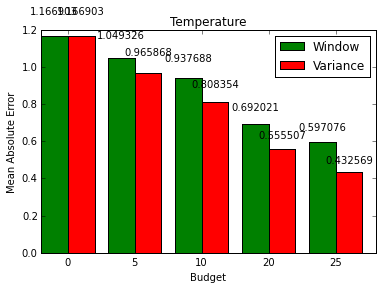

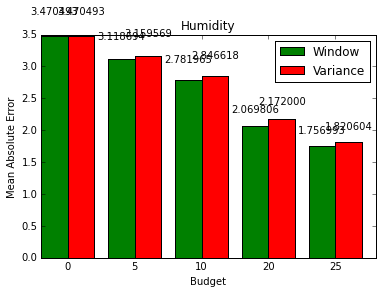

In [17]:
plot([0,5,10,20,25],predictions)